In [1]:
#import packages.berserk.berserk as berserk
import packages.pgnToFen.pgntofen as pgntofen
import json
from types import SimpleNamespace
import pandas as pd
import os
import urllib
from urllib.error import HTTPError
import time
import chess
import chess.polyglot
import pgnhelper.eco
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Opening explorer
### Parameters
- `variant` (str) – variant
- `fen` (str) – FEN of the root position
- `play` (str) – comma separated sequence of legal moves in UCI notation, play additional moves starting from fen
- `speeds` (str) – comma separated list of game speeds to look for
- `ratings` (str) – comma separated list of rating groups, ranging from their value to the next higher group (1600, 1800, 2000, 2200, 2500)
- `since` (int) – include only games from this month or later
- `until` (int) – include only games from this month or earlier
- `moves` (int) – number of most common moves to display
- `top_games` (int) – number of top games to display
- `recent_games` (int) – number of recent games to display

### Output
- `white` number of white wins from here
- `draws` number of draws from here
- `black` number of black wins from here
- `moves`:
    - `uci` Universal Chess Interface for move
    - `san` Standard Algebraic Notation for move
    - `averageRating` Average rating of players who make this move
    - `white` number of white wins from this move
    - `draws` number of draws from this move
    - `black` number of black wins from this move
- `topGames`: Top Games at this position
    - `uci` Universal Chess Interface for move
    - `id` Lichess game id (lichess.org/`id`)
    - `white`: 
        - `name` 
        - `rating`
    - `black`:
        - `name`
        - `rating`
    - `year`
    - `month`
- `recentGames`: Recent games at this position
    - `uci` Universal Chess Interface for move
    - `id` Lichess game id (lichess.org/`id`)
    - `white`:
        - `name`
        - `rating`
    - `black`:
        - `name`
        - `rating`
    - `year`
    - `month`
- `opening`:
    - `eco` Encyclopaedia of Chess Openings code
    - `name` Name


Example query: `curl https://explorer.lichess.ovh/lichess?variant=standard&speeds=blitz,rapid,classical&ratings=2200,2500&fen=rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR%20w%20KQkq%20-%200%201`

## API setup and initial search parameters

In [ ]:
API_TOKEN = 'lip_KlWcI3kORmYyk6m59gDG'

## Create list to store results of recursive function
uid=0
r_list = []
base_url = "https://explorer.lichess.ovh/lichess"
play=[]
start_depth = 0
max_depth = 5

search_params = {
    'id':0,
    'variant':'standard',
    'fen':None,
    'play':"",
    'speeds':"rapid",
    'ratings':"1600",
    'since':"1952-01",
    'until':'3000-12',
    'moves':5,
    'topGames':0,
    'recentGames':0
}

## Opening Tree Search
The function `opening_tree_search(search_params,depth)` is a recursive function that takes in the search parameters defined in `search_params`, and sends a query to the lichess API for all openings/game states that match said parameters. It starts at the board position defined in `search_params['fen']`, and returns n most frequent moves where n = `search_params['moves']`. For each of these moves, it then recursively calls itself; increasing the depth each time it does; until the depth reaches `max_depth`. Each run will store information about the number of games that made the move as well as the win percentages for white/draw/black. These are appended to a global list `r_list`. 


I've limited the search to check if a move is made at least 10% of the time. However, even down branches with say 100 games, this will still apply, even though this is a branch I'm unlikely to go down. So I'm also going to have a check to see if there are more than 1000 games, to limit my search. 

In [ ]:
def opening_tree_search(search_params,depth):
    time.sleep(0.7)
    if depth < max_depth:
        if (depth % 1 == 0):
            colour = 'w'
        else: 
            colour = 'b'
        depth+=0.5
        # print('======= Depth: ' + str(depth) + ' =======')
        cleaned_params = {k: v for k,v in search_params.items() if v is not None}
        encoded_params = urllib.parse.urlencode(cleaned_params,safe='/',quote_via=urllib.parse.quote)
        query_string = (f'{base_url}?{encoded_params}')
        try:
            response = urllib.request.urlopen(query_string)
        except HTTPError as err:
            if err.code == 429:
                time.sleep(100)
                response = urllib.request.urlopen(query_string)
                
        ox = json.load(response)
        for move in ox['moves']:
            # print('- Move: ' + move['san'])
            new_params = search_params.copy()
            new_params['id'] += 1
            if len(new_params['play']) < 1:
                new_params['play'] = search_params['play'] + move['uci']
            else:
                new_params['play'] = search_params['play'] + ',' + move['uci']
            
            total_games = ox['white'] + ox['draws'] + ox['black']
            move_total_games = move['white'] + move['draws'] + move['black']
            move_white = move['white']
            move_draw = move['draws']
            move_black = move['black']
            # Data to store
            simple_df_dict = {
                'id': new_params['id'],
                'fen': search_params['fen'],
                'play': new_params['play'],
                'depth': depth,
                'opening':ox['opening'],
                'total_games': total_games,
                'white': move_white/move_total_games,
                'draw': move_draw/move_total_games,
                'black': move_black/move_total_games,
                'move_perc': move_total_games/total_games,
                'move': move['san'],
                'made_move': colour,
                'move_total_games': move_total_games,
                'move_white': move_white,
                'move_draw': move_draw,
                'move_black': move_black
            }        
            # if move is less than 10% of all moves from that point, skip to next move
            if move_total_games < 1000:
                continue
            if simple_df_dict['move_perc'] < 0.1:
                continue
            else:
                row = pd.DataFrame(simple_df_dict,index=[0])
                r_list.append(row)
                print(simple_df_dict['play'])
                opening_tree_search(new_params,depth)

## Run the search

In [ ]:
opening_tree_search(search_params,start_depth)

Merge results list into dataframe and save as pkl/csv. 

In [ ]:
simple_df = pd.concat(r_list,axis=0,ignore_index=True)

## Generating FEN and discovering openings for each game state
Need to know opening, PGN and FEN. At the moment the games are described as move sequences in UCI notation, and this is stored as LAN(Long Algebraic Format) in a single string under `play`. So, need to:
- Convert each `play` string into list of UCI strings in LAN
- For each of these play sequence lists:
    - Create a chess board from chess library
    - Push all moves using the `board.push_uci(uci)` function 
- Then to get fen, we run `Board.fen`
- Then to get opening, we search our dictionary of openings; `eco_dict`

In [64]:
simple_df = pd.read_csv('raw_results.csv')

In [65]:
simple_df['play'] = simple_df['play'].str.strip("[]")
simple_df['play'] = simple_df['play'].str.split(',')

In [66]:
print(simple_df['play'][0][0])

'e2e4'


In [67]:
a = "'test'"
b = "test"

In [68]:
print(a)
print(b)

'test'
test


In [69]:
# Create dictionary of openings
eco_dict = pgnhelper.eco.create_eco_db('eco.pgn')

The following code:
- Reads the saved pickle
- Resets the index (All had index of 0 previously, as they were individual series)
- Transforms the `play` column values from one string to a list of UCI strings
- For each row, create a chess board, then make the moves listed in `play` for that row
- After all moves have been added to board, we grab the board fen. 
- Fen format inconsistent between board fen and fen in the `eco_dict` opening dictionary, so we capture the part that is consistent with regex. 
- Not sure if there are openings here that are missed, but broadly happy with this at the moment. 

In [70]:
simple_df.reset_index()
#simple_df.insert(5,'variation','')
#simple_df['play'] = simple_df['play'].str.strip('[]')
for i, row in simple_df.iterrows():
    board = chess.Board()
    moves = row['play']
    for move in moves:
        move = move.strip("' '")
        board.push_uci(move)
    fen = str(board.fen())
    if re.search(".*-",fen):
        fen = re.search(".*-",fen).group()
        simple_df.at[i,'fen'] = fen
    if fen in eco_dict:
        opening = eco_dict[fen]['opening']
        variation = eco_dict[fen]['variation']
        simple_df.at[i,'opening'] = opening
        simple_df.at[i,'variation'] = variation

In [71]:
simple_df.to_pickle('processed_results.pkl')
simple_df.to_csv('processed_results.csv')

In [2]:
simple_df = pd.read_pickle('processed_results.pkl')

## Best white opening
We need to make the assumption that as white we will always play the best move. This assumption is based on the fact that we are able to learn the best move, but we can't always anticipate what black will do.
To this end, I think we need to first calculate what constitutes a good win, i.e. white win percentage - black win percentage? Or perhaps draw has some value too? Maybe objectively just white win percentage. Perhaps we can try all 3 approaches. So, we need to:
- Drop the columns `total_games`,`white`,`draw`,`black`
- Calculate white/draw/black win percentage as each/`move_total_games`

Now I'm planning the next steps, I'm realising this needs considerable thought in terms of how I model the games. Maybe a quick look at probability/game theory might help. I want to know if I should simulate games, and choose the opening with the highest chance of success, or if there is a way to represent the best strategy more empirically/mathematically. I think it would be useful to know the percentage of games that take the move given; `move_chance`. 

Now we have:
- `depth`: The depth this move is at
- `play`: The sequence of moves that led up to this game state
- `move`: The latest move made
- `move_perc`: The proportion of games where this move was made
- `white`: The percentage of games where white wins from this point
- `draw`: The percentage of games where draw from this point 
- `black`: The percentage of games where black wins from this point 
- `opening`: The opening name at this position
- `variation`: The variation name of the opening at this position

Before embarking on more thorough examination, I want to remember my intention: I want a strategy that has:
- A high rate of success
- Minimal deviation below this rate of success

Lets start by plotting our table, with the `depth` on the x axis, and the white win rate on the y axis. 


In [4]:
simple_df.sort_values('depth',inplace=True)

C:\Users\gq19765\AppData\Local\Temp\ipykernel_8624\890939993.py:1: FutureWarning: In a future version of pandas all arguments of Series.sort_values will be keyword-only.
  simple_df.sort_values('depth',inplace=True)


ValueError: No axis named depth for object type Series

In [74]:
import plotly.express as px
fig = px.line(simple_df,x='depth',y='white',color='opening')
fig.show()

1. Choose starting points
2. For each starting point, iterate through the next possible moves by searching the dataframe for sequence matches with one extra UCI string. 
3. Do this for each step in depth(0.5):
    - Calculate the highest win rate for upper bound
    - Calculate the lowest win rate for lower bound
    - Calculate the average for main line to be plotted
    - If black, look at all following moves. If white, choose best move and stick with that. 
Each step will include more strings, and the variation is expected to become larger over time. 

# TODO
- Think about imposing limitations on movesets with a very small percentage of total games. Why explore each branch equally when some have many moves and others have so few? 
- Have two separate sections of this file:
    - One for finding best white opening
    - One for finding best black defence
- Add whose turn it is - can base either off the fen - b or w, or base off incrementing depth by 0.5. Whole numbers are white, x.5 is black. 

These starting points are fairly arbitrary. These are all the game points at which the move made is more than 10% of all moves that could have been made at that point. When white has made two moves, and black one, we have 10 openings, which is a nice number to start to compare:
- 1. e4 *(66.2%)*
    - 1. e4 e5 *(51.9%)*
        - 2. Nf3 *(65.6%)*
        - 2. Bc4 *(13.0%)*
    - 1. e4 c5 *(17.7%)*
        - 2. Nf3 *(51.5%)*
        - 2. Bc4 *(17.7%)*
- 1. d4 (23%)
    - 1. d4 Nf6 *(51.9%)*
        - 2. c4 *(40.8%)*
        - 2. Bf4 *(17.8%)*
        - 2. Nf3 *(13.7%)*
    - 1. d4 d5 *(17.2%)*
        - 2. c4 *(42.0%)*
        - 2. Bf4 *(19.8%)*
        - 2. Nf3 *(13.7%)*



In [75]:
simple_df['play'].head()

0                  ['e2e4']
66794              ['d2d4']
1         ['e2e4',  'e7e5']
64929     ['e2e4',  'c7c6']
129748    ['d2d4',  'e7e6']
Name: play, dtype: object

In [76]:
simple_df['play'] = simple_df['play'].astype('string')
simple_df['play'] = simple_df['play'].apply(lambda x : str(str(x).strip("[]")))

In [77]:
simple_df['play'].head()

0                    "'e2e4'"
66794                "'d2d4'"
1         "'e2e4'", " 'e7e5'"
64929     "'e2e4'", " 'c7c6'"
129748    "'d2d4'", " 'e7e6'"
Name: play, dtype: object

In [78]:
moves_lists = {}
for x in range(10,0,-1):
    depth = (x/2)
    move_list = simple_df[simple_df.depth == depth]['play']
    moves_lists.update({depth:move_list})

In [82]:
def calculate_bounds(depth,max_depth):
    if depth != max_depth:
        children_i = moves_lists[depth+0.5].index                       # List of child moves
    current_i = moves_lists[depth].index                            # List of current moves
    
    if depth == max_depth:
        simple_df.loc[current_i,'max_win'] = simple_df.loc[current_i,'white']
        simple_df.loc[current_i,'min_win'] = simple_df.loc[current_i,'white']
        simple_df.loc[current_i,'avg_win'] = simple_df.loc[current_i,'white']
        simple_df.loc[current_i,'variance'] = 0
    else:
        for i in current_i:
            print("Move: " + str(i))
            search_string = str(moves_lists[depth][i])
            match_i = simple_df.loc[children_i,'play'].str.contains(search_string).copy()
            match_i = match_i[match_i].index
            if len(match_i) == 0:
                simple_df.loc[i,'max_win'] = simple_df.loc[i,'white']
                simple_df.loc[i,'min_win'] = simple_df.loc[i,'white']
                simple_df.loc[i,'avg_win'] = simple_df.loc[i,'white']
                simple_df.loc[i,'variance'] = simple_df.loc[i,'white']
            else:
                print("Found matches")
                simple_df.loc[i,'max_win'] = simple_df.loc[match_i,'max_win'].max()
                simple_df.loc[i,'min_win'] = simple_df.loc[match_i,'min_win'].min()
                simple_df.loc[i,'avg_win'] = simple_df.loc[match_i,'avg_win'].mean()
                simple_df.loc[i,'variance'] = simple_df.loc[match_i,'white'].std(ddof=0)


In [83]:
for move_list in moves_lists:
    print("Depth: " + str(move_list))
    calculate_bounds(move_list,5.0)

Depth: 5.0
Depth: 4.5
Move: 52900
Found matches
Move: 114189
Found matches
Move: 46468
Move: 78105
Found matches
Move: 110030
Found matches
Move: 47174
Found matches
Move: 77423
Found matches
Move: 126710
Found matches
Move: 51633
Found matches
Move: 73457
Found matches
Move: 79456
Found matches
Move: 79795
Move: 124067
Found matches
Move: 46461
Found matches
Move: 124594
Found matches
Move: 53089
Found matches
Move: 113505
Found matches
Move: 85316
Found matches
Move: 110660
Found matches
Move: 113288
Found matches
Move: 72416
Found matches
Move: 113501
Found matches
Move: 73462
Found matches
Move: 51625
Found matches
Move: 79849
Found matches
Move: 124785
Found matches
Move: 46463
Move: 110086
Found matches
Move: 51250
Found matches
Move: 47006
Found matches
Move: 52908
Move: 73782
Found matches
Move: 86517
Found matches
Move: 77421
Found matches
Move: 72241
Found matches
Move: 51638
Found matches
Move: 124591
Found matches
Move: 46467
Move: 113498
Found matches
Move: 114097
Found ma

## Scatter-plot of game win-rate at that point in the opening tree
Note: most entries don't have a valid opening, so this isn't representative. Value counts of openings shown lower down

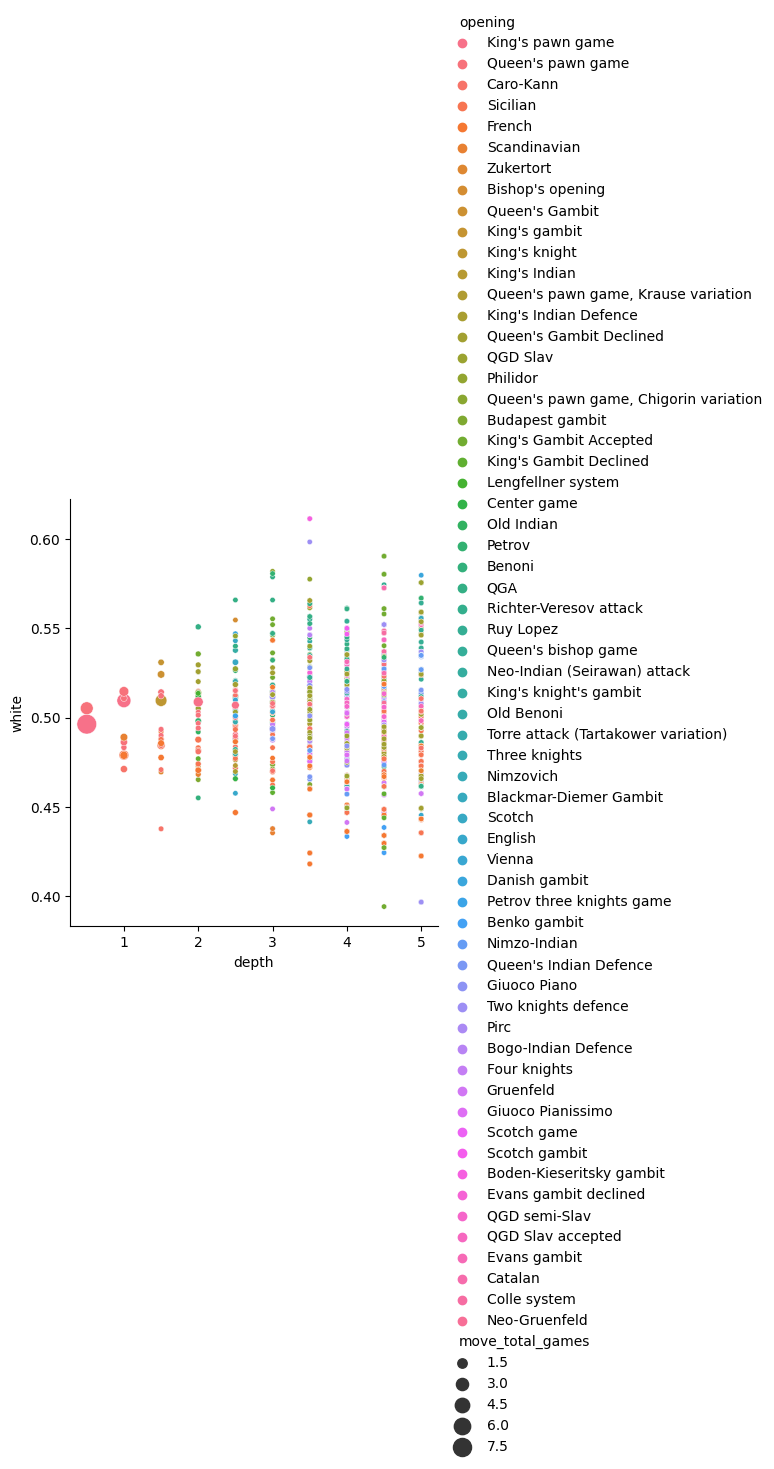

In [85]:
sns.relplot(
    data=simple_df, x="depth", y="white",
    size="move_total_games", sizes=(15, 200), hue="opening"
)

In [86]:
simple_df['opening'].value_counts()

Queen's Gambit Declined                494
QGD semi-Slav                          322
French                                 281
Sicilian                               228
Nimzo-Indian                           194
                                      ... 
King's knight                            1
King's gambit                            1
Queen's Gambit                           1
Zukertort                                1
Queen's pawn game, Krause variation      1
Name: opening, Length: 62, dtype: int64

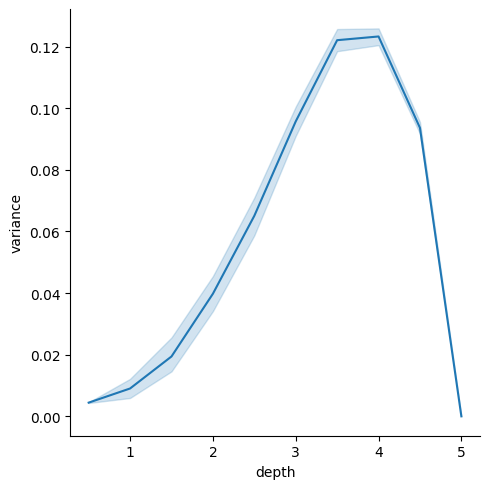

In [87]:
sns.relplot(
    data=simple_df, x="depth", y="variance", kind="line", markers=True
)

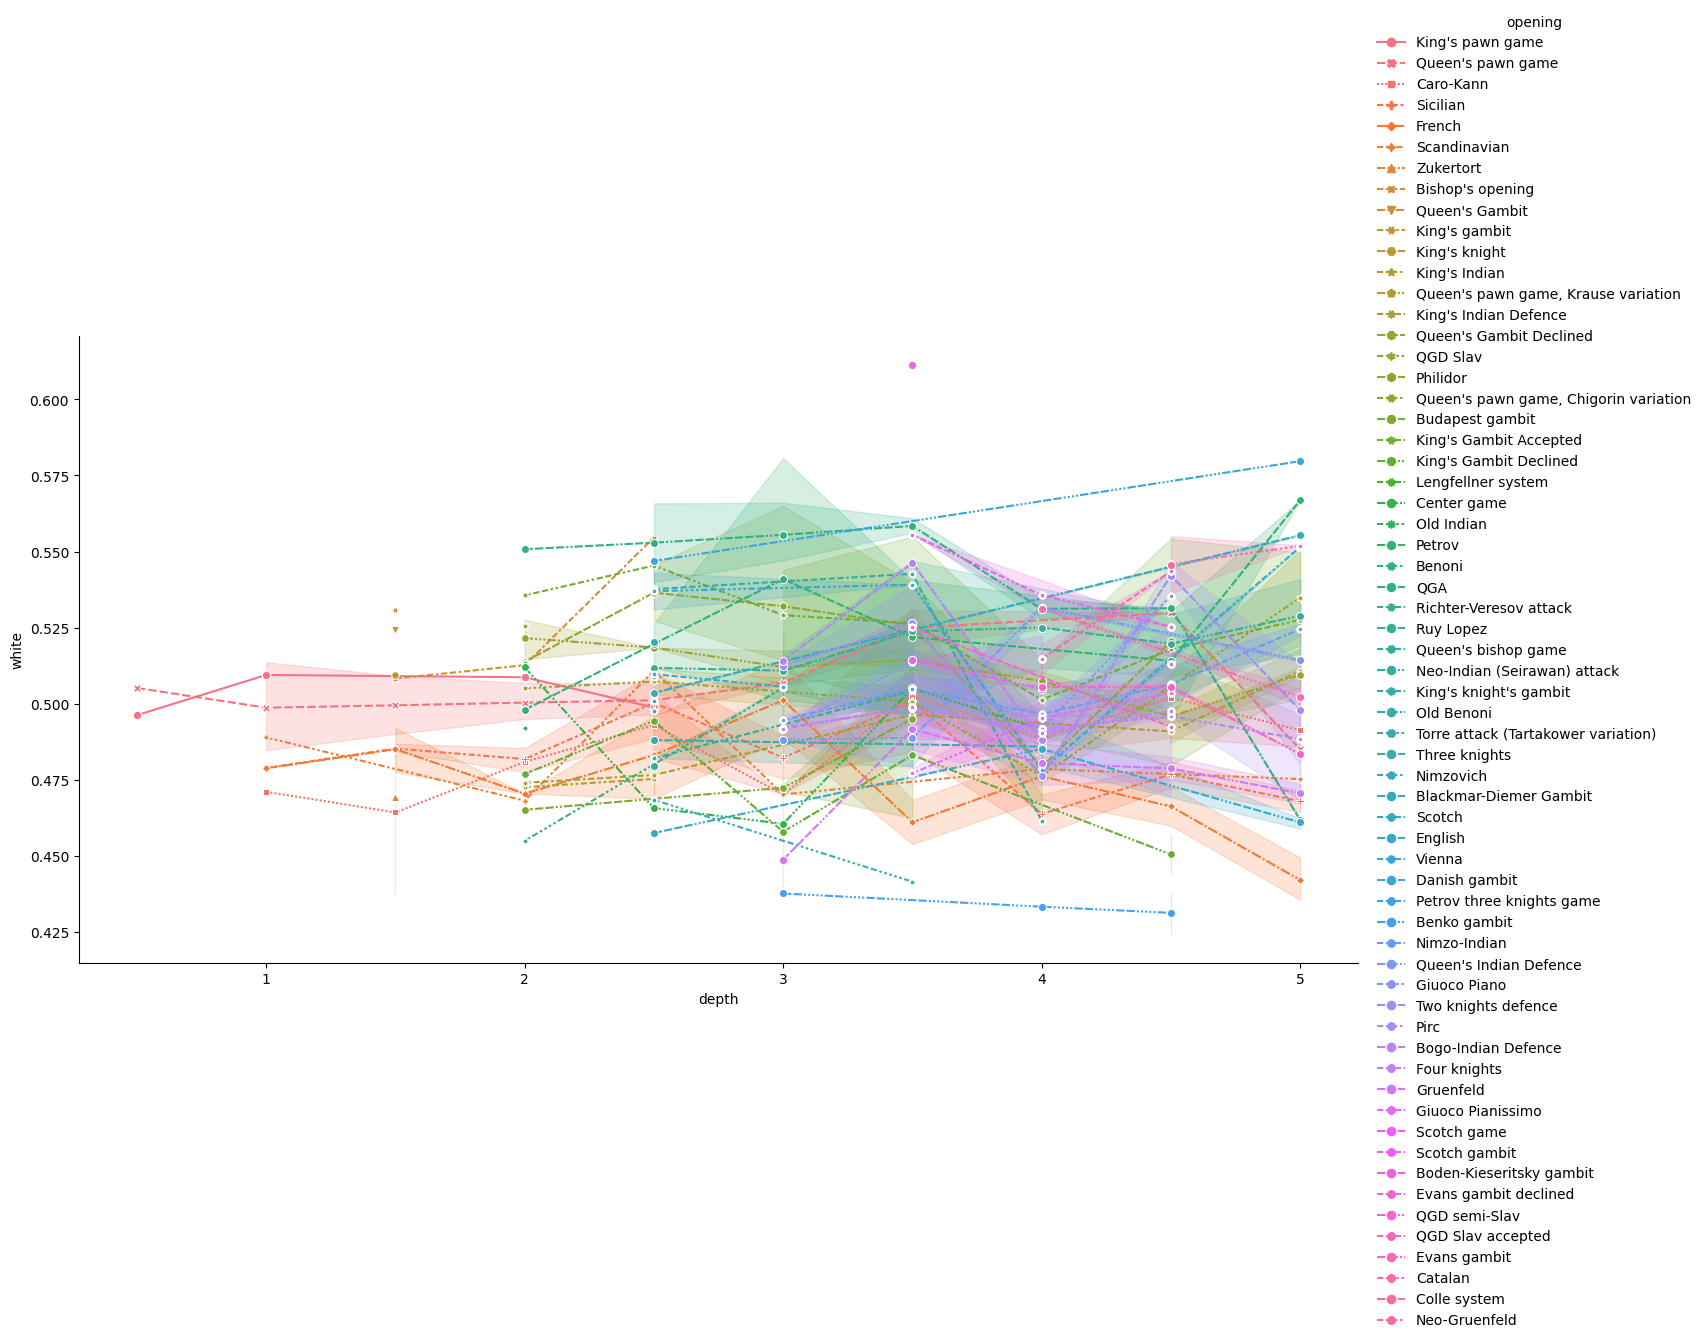

In [88]:
sns.relplot(
    data=simple_df, x="depth", y="white", kind="line", hue="opening",style='opening', markers=True, height=7, aspect=2
)

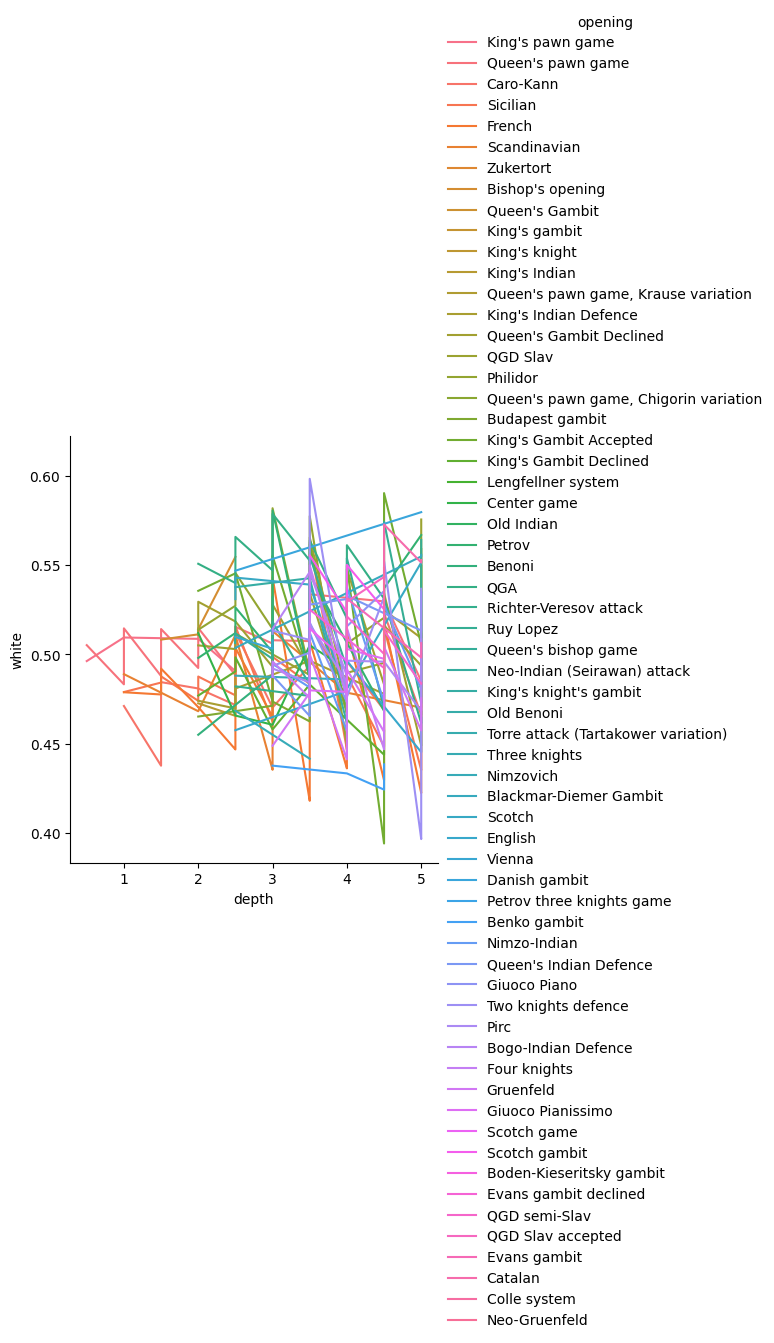

In [89]:
sns.relplot(
    data=simple_df, x="depth", y="white", kind="line", hue="opening", estimator=None
)

## Simulation
- Here's the  idea: As white, we have choice. Black is the other player, and so we have no control over what they do. 
- When simulating games like this, we can have black's moves be a probability, based on the frequencies of that move being made as stored in the dataframe from the lichess API. 
- Then, for white's move, we can try selecting the move with the highest average win rate, or the highest win rate with the lowest deviation. I guess we want to subtract the standard deviation from the average, to give us a good metric for choice. 

In [90]:
simple_df.rename(columns={'variance':'standard_deviation'}, inplace=True)
simple_df['score'] = simple_df['avg_win'] - simple_df['standard_deviation']

In [91]:
def black_turn(moves):
    weights = moves['move_perc'].copy() / moves['move_perc'].copy().sum()
    move = moves.loc[np.random.choice(moves.index,1,p=weights)].copy()
    return move
    
def white_turn(moves):
    move = moves.loc[[moves['score'].idxmax()]].copy()
    return move

def game_simulation(df,start_depth,max_depth):
    play = ''
    for turn in range(start_depth,max_depth):
        depth = float(turn/2.0)
        moves = df.query('play.str.contains(@play) and depth==@depth').copy()
        if len(moves) == 0:
            continue
        if depth == 5.0:
            if (turn%2==0):
                result = black_turn(moves)
            else:
                result = white_turn(moves)
            return result
        else:
            if (turn%2==0):
                result = black_turn(moves)
                play = str(result['play'].tolist()[0])
            else:
                result = white_turn(moves)
                play = str(result['play'].tolist()[0])        

In [92]:
results = []
for game in range(0,1000):
    result = game_simulation(simple_df,1,11)
    results.append(result)
results = pd.concat(results,axis=0,ignore_index=True)

In [93]:
import plotly.express as px
fig = px.histogram(results, x="white",
                   marginal="box", # or violin, rug
                   hover_data=results.columns)
fig.show()

Problem here is we don't know what opening led to this success, so it would be nice to have the opening labelled. Many of these results don't have labelled openings, so we will "carry through" earlier openings if they don't exist. 

We'll have a quick look at the proportion of named openings for different depths, and based on the highest depth with a reasonably high proportion of openings, we'll grab the first few elements of the results table's play sequences, grab the appropriate number of moves, find the opening in the eco dictonary, and then append this opening to the end of the results. Finally, we will plot said openings and see which opening led to the highest rate of success. 

In [94]:
for depth in ([0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0]):
    openings = simple_df.query('depth == @depth')['opening']
    print("Proportion of openings present for depth = " + str(depth))
    print(str(((len(openings) - openings.isnull().sum())/len(openings))*100) + "%")

Proportion of openings present for depth = 0.5
100.0%
Proportion of openings present for depth = 1.0
100.0%
Proportion of openings present for depth = 1.5
52.63157894736842%
Proportion of openings present for depth = 2.0
25.850340136054424%
Proportion of openings present for depth = 2.5
14.802631578947366%
Proportion of openings present for depth = 3.0
5.171664493698392%
Proportion of openings present for depth = 3.5
4.40073581434838%
Proportion of openings present for depth = 4.0
3.0684583641942655%
Proportion of openings present for depth = 4.5
2.084002754188662%
Proportion of openings present for depth = 5.0
1.0358673695620042%


In [95]:
openings = results['opening']
print(str(((len(openings) - openings.isnull().sum())/len(openings))*100) + "%")

4.509582863585118%


In [96]:
results['opening'] = results['opening'].fillna('No opening identified')
results['opening'] = results['opening'].replace('^\s*$','No opening identified', regex=True)

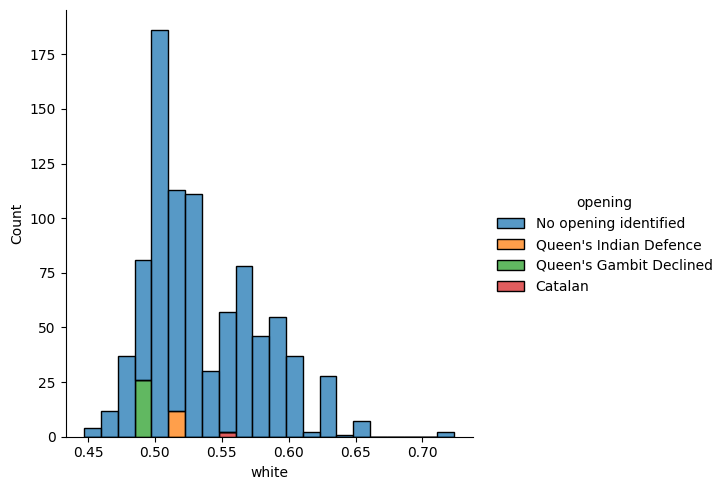

In [97]:
sns.displot(results, x="white", hue="opening", multiple="stack")

First and second move

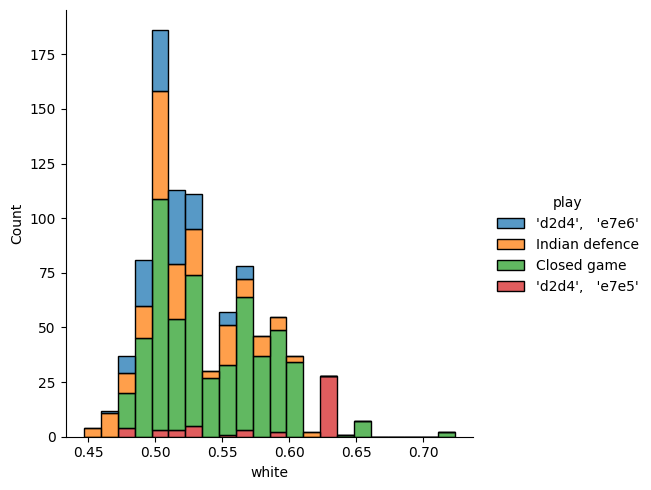

In [123]:
test = results.copy()
test['play'] = results['play'].str.replace('"','')
test['play'] = test['play'].str.split(",").replace("'",'')
test['play'] = test['play'].apply(lambda x: x[0:2])
test['play'] = test['play'].str.join(', ')
test.loc[test['play']=="'d2d4',   'd7d5'",'play'] = 'Closed game'
test.loc[test['play']=="'d2d4',   'g8f6'",'play'] = 'Indian defence'
sns.displot(test, x="white", hue="play", multiple="stack")

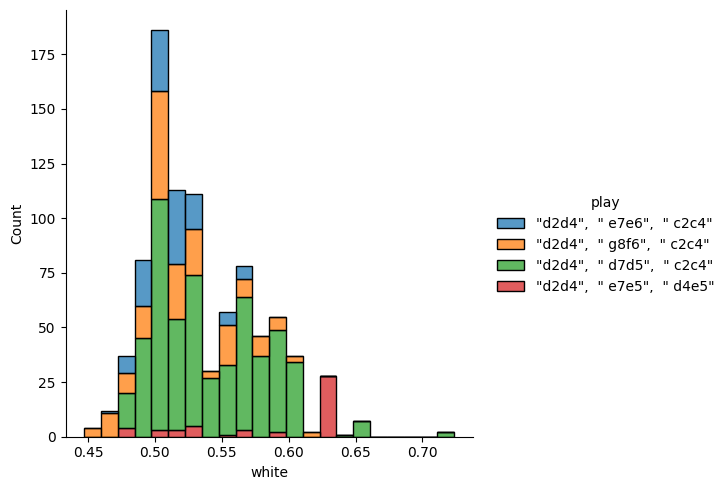

In [100]:
test = results.copy()
test['play'] = results['play'].str.replace("'","")
test['play'] = test['play'].str.split(",")
test['play'] = test['play'].apply(lambda x: x[0:3])
test['play'] = test['play'].str.join(', ')
test.loc[test['play']=="d2d4,  d7d5,  c2c4",'play'] = "The Queen's Gambit"
test.loc[test['play']=="d2d4,  g8f6,  c2c4",'play'] = 'Indian defence'
sns.displot(test, x="white", hue="play", multiple="stack")

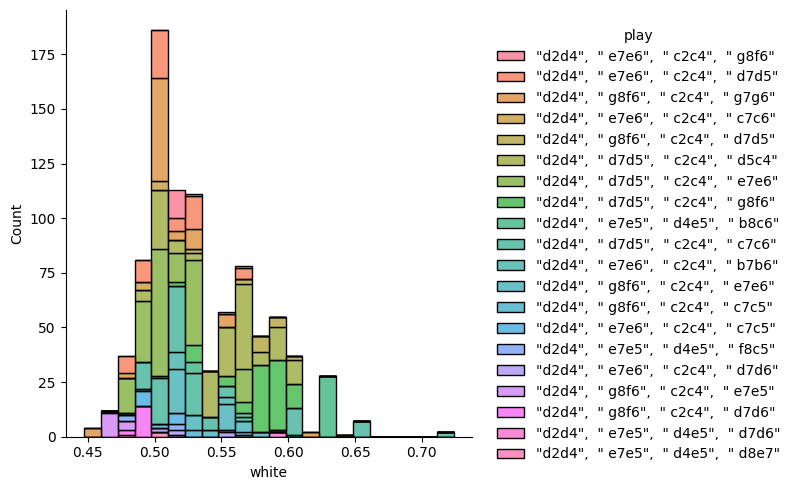

In [101]:
test = results.copy()
test['play'] = results['play'].str.replace("'","")
test['play'] = test['play'].str.split(",")
test['play'] = test['play'].apply(lambda x: x[0:4])
test['play'] = test['play'].str.join(', ')
test.loc[test['play']=="d2d4,  d7d5,  c2c4,  c7c6",'play'] = "Slav Defence"
test.loc[test['play']=="d2d4,  d7d5,  c2c4,  d5c4",'play'] = "Queen's Gambit Accepted"
test.loc[test['play']=="d2d4,  d7d5,  c2c4,  e7e6",'play'] = "Queen's Gambit Declined"
test.loc[test['play']=="d2d4,  d7d5,  c2c4,  g8f6",'play'] = "Queen's Gambit Declined: Marshall Defence"
test.loc[test['play']=="d2d4,  g8f6,  c2c4,  d7d5",'play'] = "Queen's Gambit Declined: Marshall Defence"
test.loc[test['play']=="d2d4,  g8f6,  c2c4,  g7g6",'play'] = 'Indian defence: West Indian Defence'
test.loc[test['play']=="d2d4,  g8f6,  c2c4,  e7e6",'play'] = 'Indian defence: Normal variation'
sns.displot(test, x="white", hue="play", multiple="stack")

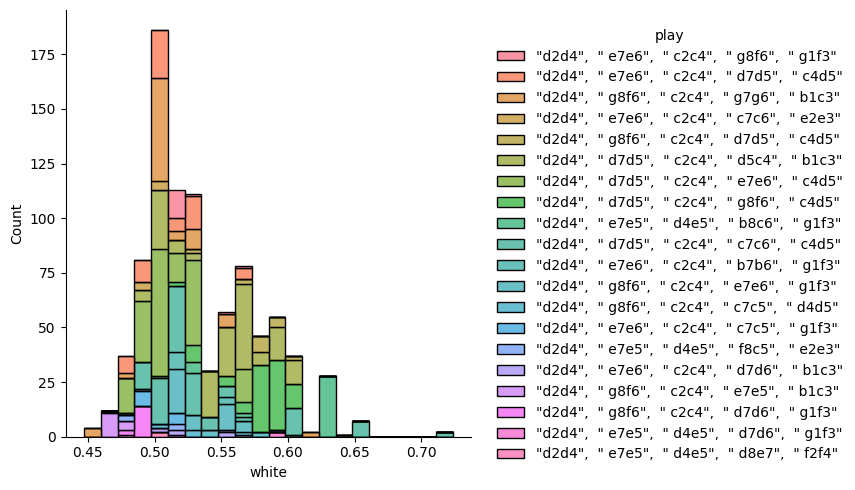

In [105]:
test = results.copy()
test['play'] = results['play'].str.replace("'","")
test['play'] = test['play'].str.split(",")
test['play'] = test['play'].apply(lambda x: x[0:5])
test['play'] = test['play'].str.join(', ')
test.loc[test['play']=="d2d4,  d7d5,  c2c4,  c7c6,  c4d5",'play'] = "Slav Defence: Exchange Variation"
test.loc[test['play']=="d2d4,  d7d5,  c2c4,  d5c4,  e2e3",'play'] = "Queen's Gambit Accepted: Old Variation"
test.loc[test['play']=="d2d4,  d7d5,  c2c4,  e7e6,  c4d5",'play'] = "Queen's Gambit Declined"
test.loc[test['play']=="d2d4,  d7d5,  c2c4,  g8f6,  c4d5",'play'] = "Queen's Gambit Declined: Marshall Defence"
test.loc[test['play']=="d2d4,  g8f6,  c2c4,  d7d5,  c4d5",'play'] = "Queen's Gambit Declined: Marshall Defence"
test.loc[test['play']=="d2d4,  g8f6,  c2c4,  g7g6,  b1c3",'play'] = "King's Indian Defence"
test.loc[test['play']=="d2d4,  g8f6,  c2c4,  e7e6,  b1c3",'play'] = 'Indian defence: Normal variation'
sns.displot(test, x="white", hue="play", multiple="stack")

"d2d4",  " d7d5",  " c2c4",  " e7e6",  " c4d5",  " e6d5"    141
"d2d4",  " d7d5",  " c2c4",  " c7c6",  " c4d5",  " c6d5"    109
"d2d4",  " d7d5",  " c2c4",  " g8f6",  " c4d5",  " f6d5"     78
"d2d4",  " g8f6",  " c2c4",  " g7g6",  " b1c3",  " f8g7"     64
"d2d4",  " e7e6",  " c2c4",  " d7d5",  " c4d5",  " e6d5"     58
"d2d4",  " d7d5",  " c2c4",  " d5c4",  " b1c3",  " e7e6"     52
"d2d4",  " d7d5",  " c2c4",  " d5c4",  " b1c3",  " g8f6"     41
"d2d4",  " g8f6",  " c2c4",  " e7e6",  " g1f3",  " d7d5"     35
"d2d4",  " d7d5",  " c2c4",  " e7e6",  " c4d5",  " d8d5"     28
"d2d4",  " e7e5",  " d4e5",  " b8c6",  " g1f3",  " d8e7"     28
"d2d4",  " d7d5",  " c2c4",  " d5c4",  " b1c3",  " b8c6"     21
"d2d4",  " d7d5",  " c2c4",  " d5c4",  " b1c3",  " c7c6"     19
"d2d4",  " d7d5",  " c2c4",  " g8f6",  " c4d5",  " d8d5"     16
"d2d4",  " g8f6",  " c2c4",  " d7d5",  " c4d5",  " f6d5"     16
"d2d4",  " g8f6",  " c2c4",  " e7e5",  " b1c3",  " e5d4"     15
"d2d4",  " d7d5",  " c2c4",  " d5c4",  "

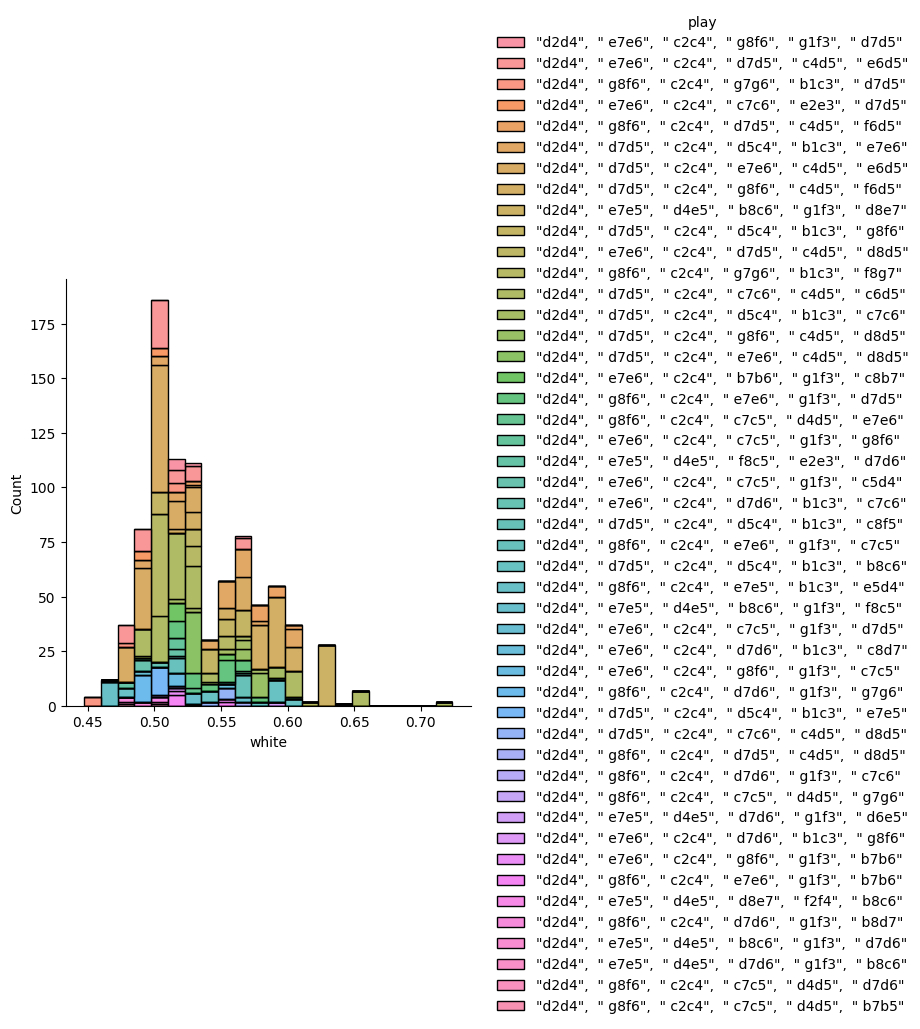

In [103]:
test = results.copy()
test['play'] = results['play'].str.replace("'","")
test['play'] = test['play'].str.split(",")
test['play'] = test['play'].apply(lambda x: x[0:6])
test['play'] = test['play'].str.join(', ')

test.loc[test['play']=="d2d4,  d7d5,  c2c4,  e7e6,  c4d5,  e6d5",'play'] = "Queen's Gambit Declined"
test.loc[test['play']=="d2d4,  d7d5,  c2c4,  c7c6,  c4d5,  c6d5",'play'] = "Slav Defence: Exchange Variation"
test.loc[test['play']=="d2d4,  d7d5,  c2c4,  d5c4,  e2e3,  b7b5",'play'] = "Queen's Gambit Accepted: Old Variation"
test.loc[test['play']=="d2d4,  d7d5,  c2c4,  g8f6,  c4d5,  f6d5",'play'] = "Queen's Gambit Declined: Marshall Defence"
test.loc[test['play']=="d2d4,  d7d5,  c2c4,  d5c4,  e2e3,  g8f6",'play'] = "Queen's Gambit Accepted: Old Variation"
test.loc[test['play']=="d2d4,  g8f6,  c2c4,  g7g6,  b1c3,  f8g7",'play'] = "King's Indian Defence"
test.loc[test['play']=="d2d4,  g8f6,  c2c4,  e7e6,  b1c3,  f8b4",'play'] = "Nimzo-Indian Defence"
test.loc[test['play']=="d2d4,  d7d5,  c2c4,  d5c4,  e2e3,  e7e6",'play'] = "Queen's Gambit Accepted: Old Variation"
test.loc[test['play']=="d2d4,  d7d5,  c2c4,  e7e6,  c4d5,  d8d5",'play'] = "Queen's Gambit Declined"
test.loc[test['play']=="d2d4,  g8f6,  c2c4,  e7e6,  b1c3,  d7d5",'play'] = "Queen's Gambit Declined: Normal Defence"
test.loc[test['play']=="d2d4,  g8f6,  c2c4,  d7d5,  c4d5,  f6d5",'play'] = "Queen's Gambit Declined: Marshall Defence"
test.loc[test['play']=="d2d4,  d7d5,  c2c4,  g8f6,  c4d5,  d8d5",'play'] = "Queen's Gambit Declined: Marshall Defence"
test.loc[test['play']=="d2d4,  g8f6,  c2c4,  g7g6,  b1c3,  d7d5",'play'] = 'Grunfeld Defence'
test.loc[test['play']=="d2d4,  g8f6,  c2c4,  d7d5,  c4d5,  d8d5",'play'] = "Queen's Gambit Declined: Marshall Defence"
sns.displot(test, x="white", hue="play", multiple="stack")
print(test['play'].value_counts())

In [ ]:
test = results.copy()
test['play'] = results['play'].str.replace("'","")
test['play'] = test['play'].str.split(",")
test['play'] = test['play'].apply(lambda x: x[0:7])
test['play'] = test['play'].str.join(', ')

test.loc[test['play']=="d2d4,  d7d5,  c2c4,  e7e6,  c4d5,  e6d5,  g1f3",'play'] = "Queen's Gambit Declined"
test.loc[test['play']=="d2d4,  d7d5,  c2c4,  c7c6,  c4d5,  c6d5,  b1c3",'play'] = "Slav Defence: Exchange Variation"
test.loc[test['play']=="d2d4,  d7d5,  c2c4,  d5c4,  e2e3,  b7b5,  a2a4",'play'] = "Queen's Gambit Accepted: Old Variation"
test.loc[test['play']=="d2d4,  d7d5,  c2c4,  g8f6,  c4d5,  f6d5,  e2e4",'play'] = "Queen's Gambit Declined: Marshall Defence"
test.loc[test['play']=="d2d4,  d7d5,  c2c4,  d5c4,  e2e3,  g8f6,  f1c4",'play'] = "Queen's Gambit Accepted: Old Variation"
test.loc[test['play']=="d2d4,  g8f6,  c2c4,  g7g6,  b1c3,  f8g7,  e2e4",'play'] = "King's Indian Defence: Normal Variation"
test.loc[test['play']=="d2d4,  g8f6,  c2c4,  e7e6,  b1c3,  f8b4,  a2a3",'play'] = "Nimzo-Indian Defence: Samisch Variation"
test.loc[test['play']=="d2d4,  d7d5,  c2c4,  d5c4,  e2e3,  e7e6,  f1c4",'play'] = "Queen's Gambit Accepted: Old Variation"
test.loc[test['play']=="d2d4,  d7d5,  c2c4,  e7e6,  c4d5,  d8d5,  b1c3",'play'] = "Queen's Gambit Declined"
test.loc[test['play']=="d2d4,  g8f6,  c2c4,  e7e6,  b1c3,  d7d5,  c1g5",'play'] = "Queen's Gambit Declined: Modern Variation"
test.loc[test['play']=="d2d4,  g8f6,  c2c4,  d7d5,  c4d5,  f6d5,  e2e4",'play'] = "Queen's Gambit Declined: Marshall Defence"
test.loc[test['play']=="d2d4,  d7d5,  c2c4,  g8f6,  c4d5,  d8d5,  b1c3",'play'] = "Queen's Gambit Declined: Marshall Defence"
test.loc[test['play']=="d2d4,  g8f6,  c2c4,  g7g6,  b1c3,  d7d5,  c1g5",'play'] = 'Grunfeld Defence: Stockholm Variation'
test.loc[test['play']=="d2d4,  g8f6,  c2c4,  d7d5,  c4d5,  d8d5,  b1c3",'play'] = "Queen's Gambit Declined: Marshall Defence"
sns.displot(test, x="white", hue="play", multiple="stack")
print(test['play'].value_counts())

In [ ]:
test = results.copy()
test['play'] = results['play'].str.replace("'","")
test['play'] = test['play'].str.split(",")
test['play'] = test['play'].apply(lambda x: x[0:8])
test['play'] = test['play'].str.join(', ')
test.loc[test['play']=="d2d4,  d7d5,  c2c4,  e7e6,  c4d5,  e6d5,  g1f3,  g8f6",'play'] = "Queen's Gambit Declined"
test.loc[test['play']=="d2d4,  d7d5,  c2c4,  e7e6,  c4d5,  e6d5,  g1f3,  b8c6",'play'] = "Queen's Gambit Declined"
test.loc[test['play']=="d2d4,  d7d5,  c2c4,  e7e6,  c4d5,  d8d5,  b1c3,  d5d8",'play'] = "Queen's Gambit Declined"
test.loc[test['play']=="d2d4,  d7d5,  c2c4,  e7e6,  c4d5,  d8d5,  b1c3,  f8b4",'play'] = "Queen's Gambit Declined"
test.loc[test['play']=="d2d4,  d7d5,  c2c4,  d5c4,  e2e3,  b7b5,  a2a4,  c7c6",'play'] = "Queen's Gambit Accepted: Old Variation"
test.loc[test['play']=="d2d4,  d7d5,  c2c4,  d5c4,  e2e3,  b7b5,  a2a4,  c8d7",'play'] = "Queen's Gambit Accepted: Old Variation"
test.loc[test['play']=="d2d4,  d7d5,  c2c4,  d5c4,  e2e3,  g8f6,  f1c4,  e7e6",'play'] = "Queen's Gambit Accepted: Old Variation"
test.loc[test['play']=="d2d4,  d7d5,  c2c4,  d5c4,  e2e3,  g8f6,  f1c4,  b8c6",'play'] = "Queen's Gambit Accepted: Old Variation"
test.loc[test['play']=="d2d4,  d7d5,  c2c4,  d5c4,  e2e3,  g8f6,  f1c4,  c8f5",'play'] = "Queen's Gambit Accepted: Old Variation"
test.loc[test['play']=="d2d4,  d7d5,  c2c4,  d5c4,  e2e3,  e7e6,  f1c4,  g8f6",'play'] = "Queen's Gambit Accepted: Old Variation"
test.loc[test['play']=="d2d4,  d7d5,  c2c4,  d5c4,  e2e3,  e7e6,  f1c4,  a7a6",'play'] = "Queen's Gambit Accepted: Old Variation"
test.loc[test['play']=="d2d4,  d7d5,  c2c4,  d5c4,  e2e3,  e7e6,  f1c4,  f8b4",'play'] = "Queen's Gambit Accepted: Old Variation"
test.loc[test['play']=="d2d4,  d7d5,  c2c4,  d5c4,  e2e3,  e7e6,  f1c4,  b8c6",'play'] = "Queen's Gambit Accepted: Old Variation"
test.loc[test['play']=="d2d4,  d7d5,  c2c4,  g8f6,  c4d5,  f6d5,  e2e4,  d5b6",'play'] = "Queen's Gambit Declined: Marshall Defence"
test.loc[test['play']=="d2d4,  d7d5,  c2c4,  g8f6,  c4d5,  f6d5,  e2e4,  d5f6",'play'] = "Queen's Gambit Declined: Marshall Defence"
test.loc[test['play']=="d2d4,  d7d5,  c2c4,  g8f6,  c4d5,  d8d5,  b1c3,  d5d8",'play'] = "Queen's Gambit Declined: Marshall Defence"
test.loc[test['play']=="d2d4,  d7d5,  c2c4,  g8f6,  c4d5,  d8d5,  b1c3,  d5a5",'play'] = "Queen's Gambit Declined: Marshall Defence"
test.loc[test['play']=="d2d4,  d7d5,  c2c4,  c7c6,  c4d5,  c6d5,  b1c3,  g8f6",'play'] = "Slav Defence: Exchange Variation"
test.loc[test['play']=="d2d4,  d7d5,  c2c4,  c7c6,  c4d5,  c6d5,  b1c3,  e7e6",'play'] = "Slav Defence: Exchange Variation"
test.loc[test['play']=="d2d4,  d7d5,  c2c4,  c7c6,  c4d5,  c6d5,  b1c3,  b8c6",'play'] = "Slav Defence: Exchange Variation"
test.loc[test['play']=="d2d4,  d7d5,  c2c4,  c7c6,  c4d5,  c6d5,  b1c3,  c8f5",'play'] = "Slav Defence: Exchange Variation"
test.loc[test['play']=="d2d4,  g8f6,  c2c4,  e7e6,  b1c3,  d7d5,  c1g5,  f8b4",'play'] = "Queen's Gambit Declined: Modern Variation"
test.loc[test['play']=="d2d4,  g8f6,  c2c4,  e7e6,  b1c3,  f8b4,  a2a3,  b4c3",'play'] = "Nimzo-Indian Defence: Samisch Variation"
test.loc[test['play']=="d2d4,  g8f6,  c2c4,  e7e6,  b1c3,  d7d5,  c1g5,  f8e7",'play'] = "Queen's Gambit Declined"
test.loc[test['play']=="d2d4,  g8f6,  c2c4,  d7d5,  c4d5,  d8d5,  b1c3,  d5a5",'play'] = "Queen's Gambit Declined: Marshall Defence"
test.loc[test['play']=="d2d4,  g8f6,  c2c4,  d7d5,  c4d5,  d8d5,  b1c3,  d5d8",'play'] = "Queen's Gambit Declined: Marshall Defence"
test.loc[test['play']=="d2d4,  g8f6,  c2c4,  d7d5,  c4d5,  f6d5,  e2e4,  d5f6",'play'] = "Queen's Gambit Declined: Marshall Defence"
test.loc[test['play']=="d2d4,  g8f6,  c2c4,  d7d5,  c4d5,  f6d5,  e2e4,  d5b6",'play'] = "Queen's Gambit Declined: Marshall Defence"
test.loc[test['play']=="d2d4,  g8f6,  c2c4,  g7g6,  b1c3,  f8g7,  e2e4,  d7d6",'play'] = "King's Indian Defence: Normal Variation"
test.loc[test['play']=="d2d4,  g8f6,  c2c4,  g7g6,  b1c3,  f8g7,  e2e4,  e8h8",'play'] = "King's Indian Defence: Fischer Transposition"
test.loc[test['play']=="d2d4,  g8f6,  c2c4,  g7g6,  b1c3,  d7d5,  c1g5,  f8g7",'play'] = "Grunfeld Defence: Stockholm Variation"

sns.displot(test, x="white", hue="play", multiple="stack")
print(test['play'].value_counts())

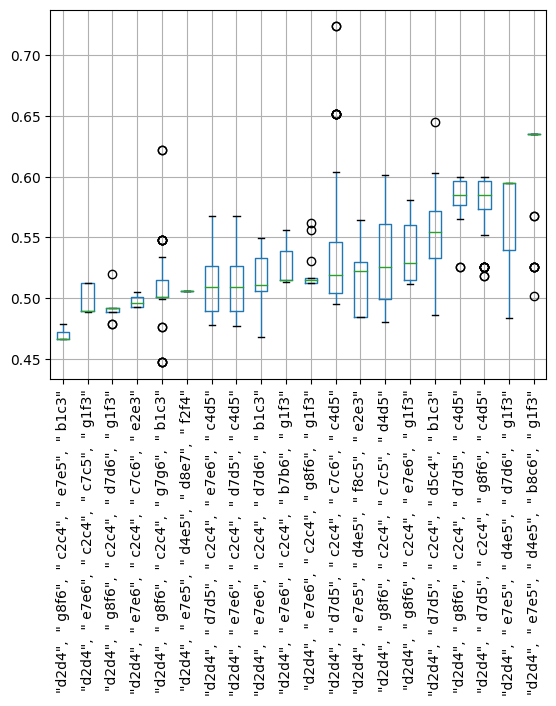

In [111]:
grouped = test.groupby("play")
df2 = pd.DataFrame({col:vals['white'] for col,vals in grouped})
meds = df2.median().sort_values()
df2 = df2[meds.index].boxplot(rot=90)


In [109]:
import plotly.express as px
fig = px.box(df2, x="play", y="white", color="play")
fig.update(layout_showlegend=False)
fig.show()

ValueError: Value of 'x' is not the name of a column in 'data_frame'. Expected one of ['"d2d4",  " e7e5",  " d4e5",  " b8c6",  " g1f3"', '"d2d4",  " e7e5",  " d4e5",  " d7d6",  " g1f3"', '"d2d4",  " d7d5",  " c2c4",  " g8f6",  " c4d5"', '"d2d4",  " g8f6",  " c2c4",  " d7d5",  " c4d5"', '"d2d4",  " d7d5",  " c2c4",  " d5c4",  " b1c3"', '"d2d4",  " g8f6",  " c2c4",  " e7e6",  " g1f3"', '"d2d4",  " g8f6",  " c2c4",  " c7c5",  " d4d5"', '"d2d4",  " e7e5",  " d4e5",  " f8c5",  " e2e3"', '"d2d4",  " d7d5",  " c2c4",  " c7c6",  " c4d5"', '"d2d4",  " e7e6",  " c2c4",  " g8f6",  " g1f3"', '"d2d4",  " e7e6",  " c2c4",  " b7b6",  " g1f3"', '"d2d4",  " e7e6",  " c2c4",  " d7d6",  " b1c3"', '"d2d4",  " e7e6",  " c2c4",  " d7d5",  " c4d5"', '"d2d4",  " d7d5",  " c2c4",  " e7e6",  " c4d5"', '"d2d4",  " e7e5",  " d4e5",  " d8e7",  " f2f4"', '"d2d4",  " g8f6",  " c2c4",  " g7g6",  " b1c3"', '"d2d4",  " e7e6",  " c2c4",  " c7c6",  " e2e3"', '"d2d4",  " g8f6",  " c2c4",  " d7d6",  " g1f3"', '"d2d4",  " e7e6",  " c2c4",  " c7c5",  " g1f3"', '"d2d4",  " g8f6",  " c2c4",  " e7e5",  " b1c3"'] but received: play

<AxesSubplot: xlabel='play'>

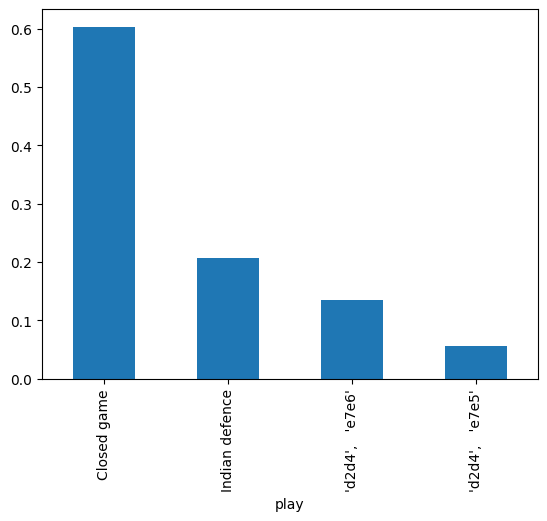

In [124]:
df_gb = test.groupby(['play']).size()/len(test['play'])
df_gb.sort_values(inplace=True,ascending=False)
df_gb.plot(kind='bar')


In [125]:
print(df_gb)

play
Closed game         0.603157
Indian defence      0.206313
'd2d4',   'e7e6'    0.135287
'd2d4',   'e7e5'    0.055242
dtype: float64


- 25% of Queen's Gambit games are accepted, leading to a high win rate of 58%
- 23% of Queen's Gambit are declined, leading to a measly win rate of 50%
- 17% of Queen's Gambit games lead to marshall defence, with another high rate of 60%
- 16% lead to Slav defence, okay win rate of 52%
- 7% lead to King's Indian defence, win rate of 50%, but this needs more investigation
- 7% lead to Nimzo, win rate of, win rate of 49%, this needs focus
- The rest can be considered insignificant

In [126]:
avg = test.groupby('play')
perc = test.groupby(['play']).size()/len(test['play'])
weighted_win = avg*perc
weighted_win

c:\Users\gq19765\SyncThing\Repositories\lichess-data-driven-improvement\chess\lib\site-packages\pandas\core\roperator.py:19: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



ValueError: operands could not be broadcast together with shapes (4,2) (4,) 